<H1> Word frequency / topic changes in congressional records</H1> 


Dependencies and Data:

In [1]:
library(readr)
library(dplyr)
library(tm)

library(tidyverse)
library(data.table)

#setwd("./Stats235 Hackathon//Code")
source("./HC_aux.R") #load functions for computing HC


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: NLP
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ stringr 1.3.1
✔ tidyr   0.8.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::annotate() masks NLP::annotate()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()

Attaching package: ‘data.table’

The following object is masked from ‘package:purrr’:

    transpose

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [2]:
raw.corpus <- read_csv("~/Google Drive/Hackathon Data/CongRec/speech_w_data_114.csv")

Parsed with column specification:
cols(
  speech_id = col_integer(),
  date = col_integer(),
  congress_id = col_integer(),
  chamber = col_character(),
  party = col_character(),
  speech = col_character()
)


<H1> Topic Modeling </H1>

In [3]:
library(topicmodels)
library(tidytext)
library(tm)

In [6]:
unit1 <- raw.corpus %>%
    filter(party == 'R', congress_id == 114) %>%
    select(speech_id, speech)

unit2 <- raw.corpus %>%
    filter(party == 'D', congress_id == 114) %>%
    select(speech_id, speech)

In [5]:
unit1.dt <- unit1 %>%
    unnest_tokens(word, speech) %>%
    mutate(word = str_extract(word, "[a-z']+")) %>%
    count(speech_id, word, sort = TRUE) %>%
    bind_tf_idf(word, speech_id, n)

In [ ]:
DTM <- unit1.dt %>%
  cast_dtm(speech_id, word, n)

ap_lda <- LDA(DTM, k = 15, control = list(seed = 1234))
ap_lda

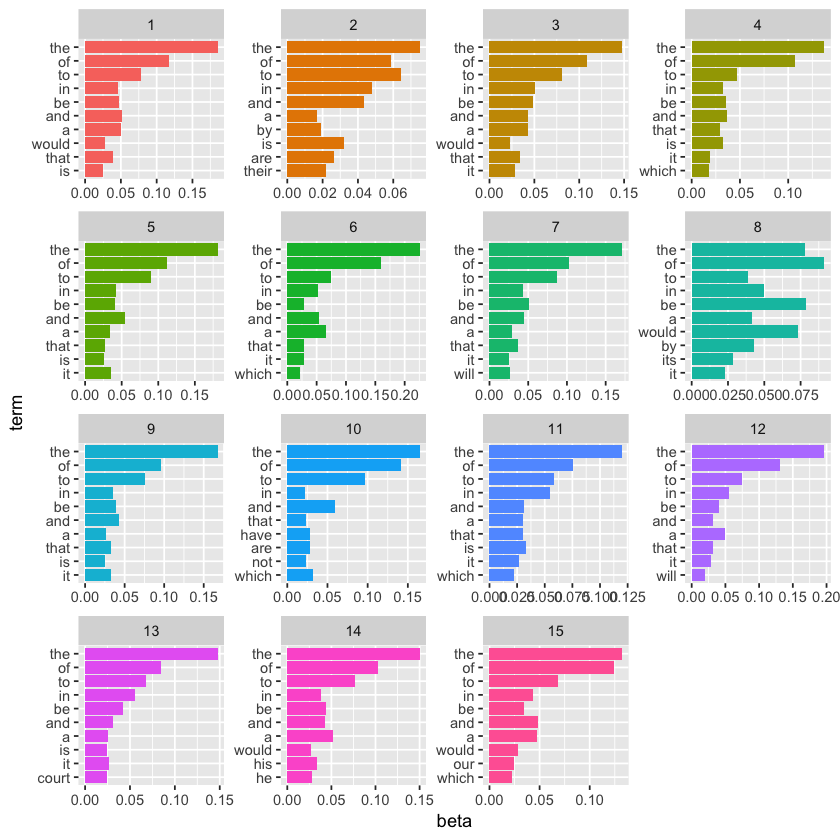

In [1022]:
gamma_ham <- tidy(ap_lda, matrix = "beta")

ap_top_terms <- gamma_ham %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

ap_top_terms %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip()

In [8]:
library(tidytext)
library(tm)

#most interesting words from each paper
unit1.dt <- unit1 %>%
    unnest_tokens(word, speech) %>%
    mutate(word = str_extract(word, "[a-z']+")) %>%
    count(speech_id, word, sort = TRUE) %>%
    bind_tf_idf(word, speech_id, n)

unit2.dt <- unit2 %>%
    unnest_tokens(word, speech) %>%
    mutate(word = str_extract(word, "[a-z']+")) %>%
    count(speech_id, word, sort = TRUE) %>%
    bind_tf_idf(word, speech_id, n) 


In [10]:
counts1 <- unit1.dt %>% 
  arrange(desc(tf_idf)) %>%
  #filter(speech_id < 1110000050) %>%
  mutate(word = factor(word, levels = rev(unique(word)))) %>% 
  group_by(speech_id) %>% 
  top_n(7) %>% 
  ungroup %>%
  count(word, sort = TRUE)

counts2 <- unit2.dt %>% 
  arrange(desc(tf_idf)) %>%
  #filter(speech_id < 1110000050) %>%
  mutate(word = factor(word, levels = rev(unique(word)))) %>% 
  group_by(speech_id) %>% 
  top_n(7) %>% 
  ungroup %>%
  count(word, sort = TRUE)
    

Selecting by tf_idf
Selecting by tf_idf


In [12]:
two.counts <- counts1 %>% 
    inner_join(counts2, by = 'word') %>%
    mutate(total.x = sum(nn.x), total.y = sum(nn.y)) %>%
    mutate(total = nn.x + nn.y) %>%
    filter(total > 10) %>%
    rowwise() %>%
        mutate(p = (nn.x+nn.y) / (total.x + total.y)) %>%
        mutate(se = sqrt(p*(1-p)*(1/total.x + 1/ total.y))) %>%
        mutate(z.score = (nn.x /total.x - nn.y / total.y) / se) %>%
        mutate(pval = 2*pnorm(-abs(z.score))) %>%
        mutate(pval2 = binom.test(n = nn.x+nn.y, x = nn.x,
                                  p = (total.x - nn.x) / (total.y + total.x - nn.x - nn.y),
                                  alt = "two.sided")$p.value) %>%
    dplyr::select(word, nn.x, nn.y, pval, pval2) 
    
hc = hc.vals(two.counts$pval, alpha = 0.5)
hc2 = hc.vals(two.counts$pval2, alpha = 0.5)
print(hc$hc.star)
print(hc2$hc.star)
HC <- data_frame(uu = hc$uu, zz = hc$z, pp = hc$p.sorted, word = two.counts$word[hc$p.sorted_idx])

Warning message:
“Column `word` joining factors with different levels, coercing to character vector”

[1] 5.753045
NULL


In [18]:
two.counts %>%
    arrange(desc(pval)) %>%
    top_n(20)

Selecting by pval2


word,nn.x,nn.y,pval,pval2
america,17,10,0.9962076,1
framework,17,10,0.9962076,1
higher,17,10,0.9962076,1
deals,17,10,0.9962076,1
nigeria,17,10,0.9962076,1
intelligence,104,61,0.9950764,1
assistance,34,20,0.9946363,1
port,34,20,0.9946363,1
private,41,24,0.9906978,1
courage,12,7,0.9891383,1


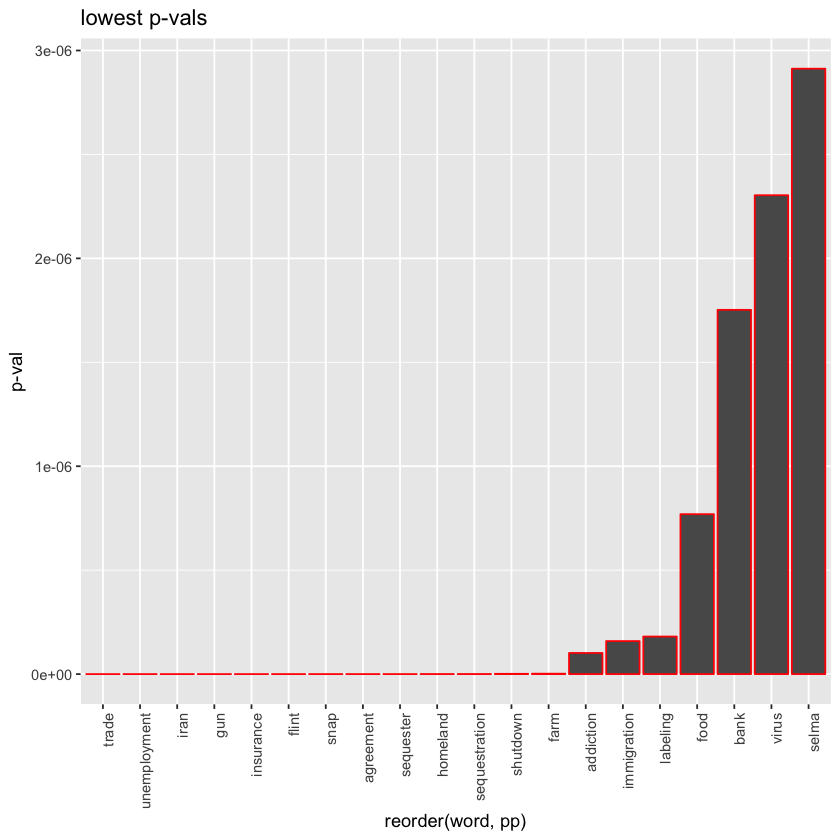

In [104]:
#lowest p-values 
#HC %>% arrange(desc(pp)) %>% top_n(-20, pp) 

HC %>%
    top_n(-20, pp) %>%
    ggplot(aes(reorder(word, pp), pp)) + 
    geom_col(colour = 'red') + 
    ylab('p-val') +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    ggtitle("lowest p-vals")

Selecting by tf_idf


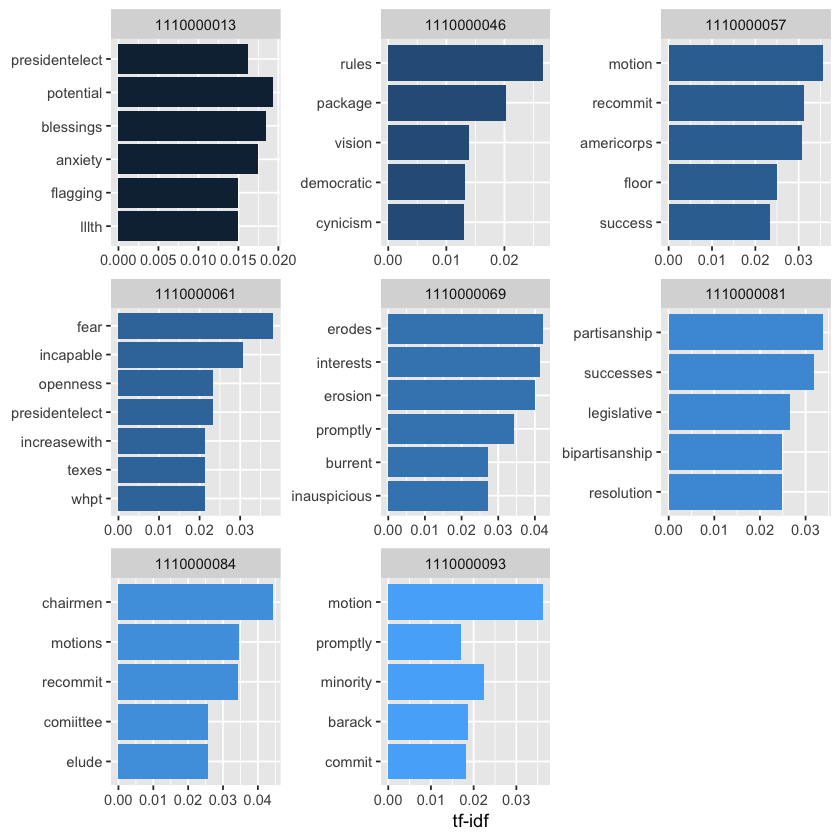

In [25]:
unit1.dt %>%
  arrange(desc(tf_idf)) %>%
  filter(speech_id < 1110000100) %>%
  mutate(word = factor(word, levels = rev(unique(word)))) %>% 
  group_by(speech_id) %>% 
  top_n(5) %>% 
  ungroup %>%
  ggplot(aes(word, tf_idf, fill = speech_id)) +
  geom_col(show.legend = FALSE) +
  labs(x = NULL, y = "tf-idf") +
  facet_wrap(~speech_id, ncol = 3, scales = "free") +
  coord_flip()